In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install tensorflow
!pip install keras
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrad

In [517]:
data = pd.read_csv('converted.csv')
data = data.head(84*30)
#data['Inflation (Can)'] = data['Inflation (Can)'].shift(-30)
#data.drop([84],inplace=True)
data.drop(['Period'],axis=1,inplace=True)

In [534]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
y = scaled_data[:,0]
x = scaled_data[:,1:]
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
scaled_data = pca.fit_transform(x)

In [535]:
train_X = scaled_data[:72*30]
train_y = y[:72*30]
test_X = scaled_data[72*30:84*30]
test_y = y[72*30:84*30]

#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [551]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [541]:
svr = SVR()
svr.fit(train_X,train_y)
svr.score(test_X,test_y)

0.08994615151887286

In [552]:
para = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'tol' : [0.001,0.01],
    'C' : [0.8,1,1.2]
}
grid_ser = GridSearchCV(SVR(),scoring = 'neg_mean_absolute_error',param_grid=para ,n_jobs =5,cv = 4,verbose=5)
grid_ser.fit(train_X,train_y)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done  96 out of  96 | elapsed:    9.4s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=5,
             param_grid={'C': [0.8, 1, 1.2],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'tol': [0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=5)

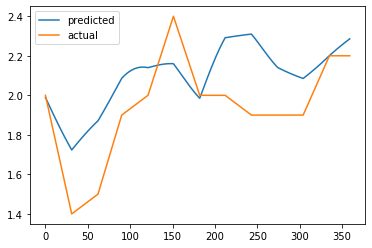

In [578]:
a = scaler.inverse_transform(
    concatenate(
        (grid_ser.best_estimator_.predict(test_X).reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

b = scaler.inverse_transform(
    concatenate(
        (test_y.reshape(360,-1),pca.inverse_transform(test_X)),
         axis=1
    )
)[:,0]

pyplot.plot(a, label='predicted')
pyplot.plot(b, label='actual')
pyplot.legend()
pyplot.show()

In [585]:
mean_squared_error(a,b)

0.05260126933387546

In [586]:
mean_absolute_error(a,b)

0.19871160902435756

In [587]:
from sklearn.metrics import r2_score
r2_score(a,b)

-1.2468105602810327

In [ ]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

Epoch 1/7
22/22 - 6s - loss: 0.8745 - val_loss: 0.7171
Epoch 2/7
22/22 - 0s - loss: 0.8499 - val_loss: 0.6875
Epoch 3/7
22/22 - 0s - loss: 0.7349 - val_loss: 0.5350
Epoch 4/7
22/22 - 0s - loss: 0.5910 - val_loss: 0.3999
Epoch 5/7
22/22 - 0s - loss: 0.4948 - val_loss: 0.3513
Epoch 6/7
22/22 - 0s - loss: 0.4306 - val_loss: 0.3468
Epoch 7/7
22/22 - 0s - loss: 0.3838 - val_loss: 0.3574


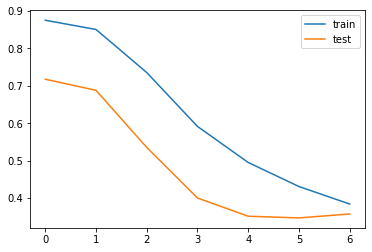

In [483]:
model = Sequential()

model.add(LSTM(128,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(16,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=7, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

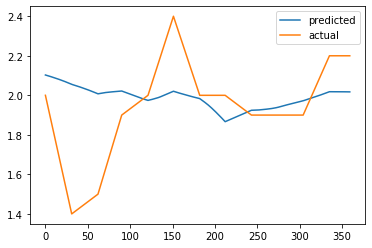

In [484]:
yhat = model.predict(test_X)
test_X1 = pca.inverse_transform(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(12*30,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [ ]:
yhat = model.predict(pred_X)
test_X1 = pred_X.reshape((pred_X.shape[0], pred_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat.reshape(13,1), test_X1), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y1 = pred_y.reshape((len(pred_y), 1))
inv_y = concatenate((test_y1, test_X1), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='actual')
pyplot.legend()
pyplot.show()

In [364]:
data = pd.read_csv('raw_data.csv')
data = data.drop(['Inflation (Can)','Period'],axis=1)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)